In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [235]:

class PointLensModel:
    def __init__(self, f0, t0, td, y):
        """
        f0 is the base flux
        t0 is the time at which the lensing event happens
        y is the min distance expressed in units of einstein radius 
        td is the duration of the event
        """
        self.f0 = f0
        self.t0 = t0
        self.td = td
        self.y = y
        self.lower_bounds = [0,t0-100,0,0]
        self.upper_bounds = [(f0+10)*2,t0+100,(td+10)*2,(y+1)*2]
        print(self.lower_bounds)
        print(self.upper_bounds)

    def compute_angles(ts, t0, td, y):
        return np.sqrt(((ts-t0)/td)**2 + y**2)
                       
    def compute_magnification(angle_ratios):
        return (angle_ratios**2 + 2)/(angle_ratios*np.sqrt(angle_ratios**2 + 4))

    def compute_fluxes_fn(ts, f0, t0, td, y):
        angles = PointLensModel.compute_angles(ts, t0, td, y)
        fluxes = PointLensModel.compute_magnification(angles)*f0
        return fluxes
    
    def compute_fluxes(self, ts):
        return PointLensModel.compute_fluxes_fn(ts, self.f0, self.t0, self.td, self.y)
    
    def plot_range(self, st, et, counts = 1000):
        ts = np.linspace(st, et, counts)
        fluxes = self.compute_fluxes(ts)
        plt.plot(ts, fluxes)
        plt.show()

    def fit(self, ts, fluxes):
        popt, pcov = curve_fit(PointLensModel.compute_fluxes_fn, ts, fluxes, bounds=(self.lower_bounds, self.upper_bounds))
        print(popt)
        self.f0, self.t0, self.td, self.y = popt
    
    def mag2flux(mags):
        return 10**(22.5 - mags)/2.5

        
    
        

[0, -1, 0, 0]
[26, 22, 24, 4]


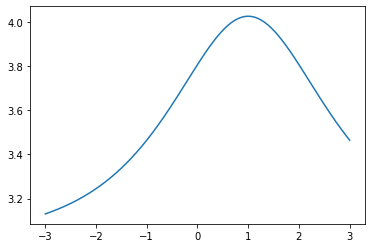

In [257]:
model = PointLensModel(3, 1, 2, 1)
model.plot_range(-3, 3)

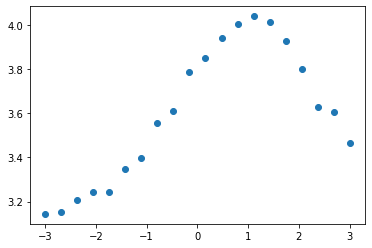

In [258]:
ts = np.linspace(-3, 3, 20)
fluxes = model.compute_fluxes(ts) + (np.random.rand((20))-0.5)/10
plt.scatter(ts, fluxes)
plt.show()

In [259]:
model.fit(ts, fluxes)

[3.01117275 1.02434843 1.94758442 1.00003542]


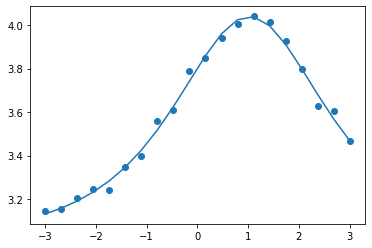

In [260]:
fluxes2 = model.compute_fluxes(ts)
plt.plot(ts, fluxes2)
plt.scatter(ts, fluxes)
plt.show()

[]

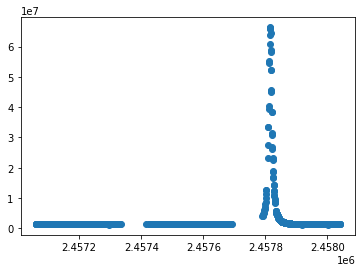

In [289]:
data = np.loadtxt('../data/phot.dat')[:, :2].transpose()
ts1 = data[0]
fluxes3 = PointLensModel.mag2flux(data[1])

maxflux = 0
minflux = min(fluxes3)
t0 = 0
for t, f in zip(ts1, fluxes3):
    if f > maxflux:
        maxflux = f
        t0 = t

plt.scatter(ts1, fluxes3)
plt.plot()


In [290]:
st = 2.45777*1e6
et = 2.45784*1e6
ts = []
fluxes = []
for t, f in zip(ts1, fluxes3):
    if t<et and t>st:
        ts.append(t)
        fluxes.append(f)

[]

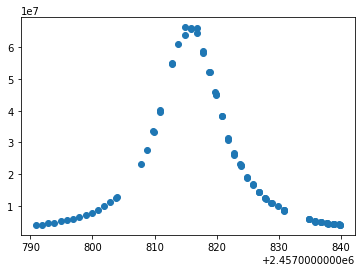

In [291]:
plt.scatter(ts, fluxes)
plt.plot()

In [292]:
model = PointLensModel(minflux,t0,0,0)

[0, -2457814.83824, 0, 0]
[2296644.4656197443, 4915649.67648, 20, 2]


[2.29664447e+06 3.66136469e+06 2.82697810e-01 1.00000000e+00]


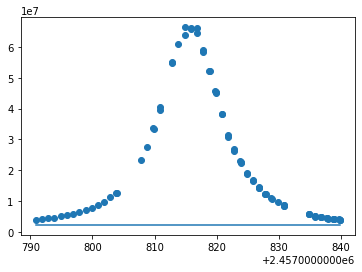

In [293]:
model.fit(ts, fluxes)
fluxes2 = model.compute_fluxes(ts)
plt.scatter(ts, fluxes)
plt.plot(ts, fluxes2)
plt.show()